# A quick overview of Harmonica

by [Santiago Soler](https://santisoler.github.io).



Import some libraries...

In [1]:
import pyproj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

...and some Fatiando a Terra libraries as well.

In [2]:
import boule as bl
import verde as vd
import harmonica as hm

## Get South Africa gravity survey data

Fetch the sample gravity data from South Africa (the original data is available through [NOAA website](https://www.ngdc.noaa.gov/mgg/gravity/1999/data/regional/africa/)).

In [3]:
data = hm.datasets.fetch_south_africa_gravity()

In [4]:
data

,latitude,longitude,elevation,gravity
0,-34.39150,17.71900,-589.0,979724.79
1,-34.48000,17.76100,-495.0,979712.90
2,-34.35400,17.77433,-406.0,979725.89
3,-34.13900,17.78500,-267.0,979701.20
4,-34.42200,17.80500,-373.0,979719.00
...,...,...,...,...
14554,-17.95833,21.22500,1053.1,978182.09
14555,-17.98333,21.27500,1033.3,978183.09
14556,-17.99166,21.70833,1041.8,978182.69
14557,-17.95833,21.85000,1033.3,978193.18


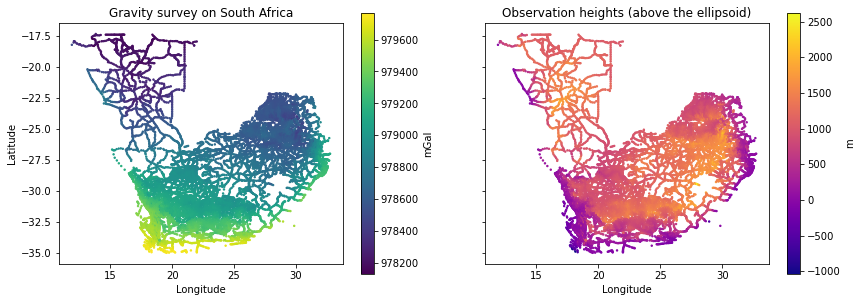

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8), sharey=True)

tmp = ax1.scatter(data.longitude, data.latitude, c=data.gravity, s=2)
ax1.set_aspect("equal") # use the same scale on both longitude and latitude axes
plt.colorbar(tmp, ax=ax1, shrink=0.6, label="mGal")
ax1.set_title("Gravity survey on South Africa")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

tmp = ax2.scatter(data.longitude, data.latitude, c=data.elevation, s=2, cmap="plasma")
ax2.set_aspect("equal")  # use the same scale on both longitude and latitude axes
plt.colorbar(tmp, ax=ax2, shrink=0.6, label="m")
ax2.set_title("Observation heights (above the ellipsoid)")
ax2.set_xlabel("Longitude")

plt.show()

Downsample the data using a blocked mean to speed-up the computations
for this example. This is preferred over simply discarding points to avoid
aliasing effects.

In [6]:
blocked_mean = vd.BlockReduce(np.mean, spacing=0.2, drop_coords=False)
(longitude, latitude, elevation), gravity_data = blocked_mean.filter(
    (data.longitude, data.latitude, data.elevation), data.gravity,
)

data = pd.DataFrame({"longitude": longitude, "latitude": latitude, "gravity": gravity_data, "elevation": elevation})

In [7]:
data

,longitude,latitude,gravity,elevation
0,18.154500,-34.890340,979734.600000,-1038.000
1,18.331665,-34.890335,979765.025000,-477.000
2,19.299585,-34.832660,979726.950000,0.000
3,19.427479,-34.882429,979740.335714,0.000
4,19.595495,-34.939500,979749.250000,0.000
...,...,...,...,...
3390,15.850664,-17.424998,978168.890000,1103.140
3391,16.020830,-17.390000,978169.965000,1108.325
3392,16.140000,-17.390000,978168.790000,1112.500
3393,18.441665,-17.437495,978157.390000,1113.900


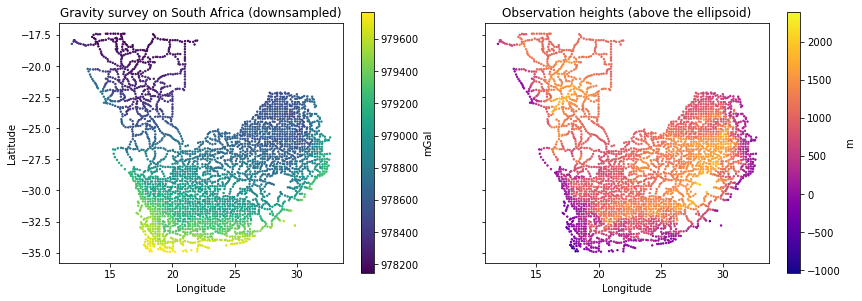

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8), sharey=True)

tmp = ax1.scatter(data.longitude, data.latitude, c=data.gravity, s=2)
ax1.set_aspect("equal") # use the same scale on both longitude and latitude axes
plt.colorbar(tmp, ax=ax1, shrink=0.6, label="mGal")
ax1.set_title("Gravity survey on South Africa (downsampled)")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

tmp = ax2.scatter(data.longitude, data.latitude, c=data.elevation, s=2, cmap="plasma")
ax2.set_aspect("equal")  # use the same scale on both longitude and latitude axes
plt.colorbar(tmp, ax=ax2, shrink=0.6, label="m")
ax2.set_title("Observation heights (above the ellipsoid)")
ax2.set_xlabel("Longitude")

plt.show()

## Compute gravity disturbance

In [9]:
ellipsoid = bl.WGS84

In [10]:
ellipsoid.normal_gravity?

Signature: ellipsoid.normal_gravity(latitude, height)
Docstring:
Calculate normal gravity at any latitude and height.

Computes the magnitude of the gradient of the gravity potential
(gravitational + centrifugal) generated by the ellipsoid at the given
latitude and (geometric) height. Uses of a closed form expression of
[LiGotze2001]_.

Parameters
----------
latitude : float or array
    The (geodetic) latitude where the normal gravity will be computed
    (in degrees).
height : float or array
    The ellipsoidal (geometric) height of computation point (in meters).

Returns
-------
gamma : float or array
    The normal gravity in mGal.
File:      ~/miniconda3/envs/t20-fatiando-lightning/lib/python3.7/site-packages/boule/ellipsoid.py
Type:      method


In [11]:
data["gravity_disturbance"] = data.gravity - ellipsoid.normal_gravity(data.latitude, data.elevation)

In [12]:
data

,longitude,latitude,gravity,elevation,gravity_disturbance
0,18.154500,-34.890340,979734.600000,-1038.000,-310.137368
1,18.331665,-34.890335,979765.025000,-477.000,-106.505487
2,19.299585,-34.832660,979726.950000,0.000,7.544608
3,19.427479,-34.882429,979740.335714,0.000,16.711542
4,19.595495,-34.939500,979749.250000,0.000,20.784635
...,...,...,...,...,...
3390,15.850664,-17.424998,978168.890000,1103.140,13.672311
3391,16.020830,-17.390000,978169.965000,1108.325,18.149462
3392,16.140000,-17.390000,978168.790000,1112.500,18.262780
3393,18.441665,-17.437495,978157.390000,1113.900,4.848344


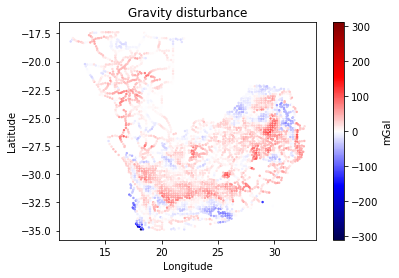

In [13]:
maxabs = vd.maxabs(data.gravity_disturbance)

tmp = plt.scatter(
    data.longitude,
    data.latitude,
    c=data.gravity_disturbance,
    s=2,
    cmap="seismic",
    vmin=-maxabs,
    vmax=maxabs,
)
plt.gca().set_aspect("equal")  # use the same scale on both longitude and latitude axes
plt.colorbar(tmp, label="mGal")
plt.title("Gravity disturbance")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Project coordinates into a Cartesian coordinate system

In [14]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

In [15]:
projection(data.longitude.values, data.latitude.values)

(array([1794920.23673635, 1812436.39216566, 1908133.83332581, ...,
        1595748.3059806 , 1823312.00019899, 1833198.4222471 ]),
 array([-3663244.96090501, -3663244.36094723, -3656326.29673045, ...,
        -1735020.73121292, -1739912.06194996, -1749785.67632276]))

In [16]:
data["easting"], data["northing"] = projection(data.longitude.values, data.latitude.values)

In [17]:
data

,longitude,latitude,gravity,elevation,gravity_disturbance,easting,northing
0,18.154500,-34.890340,979734.600000,-1038.000,-310.137368,1.794920e+06,-3.663245e+06
1,18.331665,-34.890335,979765.025000,-477.000,-106.505487,1.812436e+06,-3.663244e+06
2,19.299585,-34.832660,979726.950000,0.000,7.544608,1.908134e+06,-3.656326e+06
3,19.427479,-34.882429,979740.335714,0.000,16.711542,1.920779e+06,-3.662296e+06
4,19.595495,-34.939500,979749.250000,0.000,20.784635,1.937390e+06,-3.669146e+06
...,...,...,...,...,...,...,...
3390,15.850664,-17.424998,978168.890000,1103.140,13.672311,1.567142e+06,-1.738625e+06
3391,16.020830,-17.390000,978169.965000,1108.325,18.149462,1.583966e+06,-1.735021e+06
3392,16.140000,-17.390000,978168.790000,1112.500,18.262780,1.595748e+06,-1.735021e+06
3393,18.441665,-17.437495,978157.390000,1113.900,4.848344,1.823312e+06,-1.739912e+06


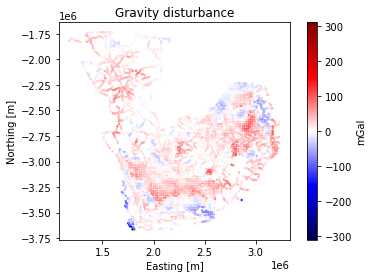

In [18]:
maxabs = vd.maxabs(data.gravity_disturbance)

tmp = plt.scatter(
    data.easting,
    data.northing,
    c=data.gravity_disturbance,
    s=2,
    cmap="seismic",
    vmin=-maxabs,
    vmax=maxabs,
)
plt.gca().set_aspect("equal")  # use the same scale on both easting and northing axes
plt.colorbar(tmp, label="mGal")
plt.title("Gravity disturbance")
plt.xlabel("Easting [m]")
plt.ylabel("Northing [m]")
plt.show()

## Grid data using Equivalent Layer

In [19]:
coordinates = (data.easting.values, data.northing.values, data.elevation.values)

gridder = hm.EQLHarmonic(relative_depth=100e3, damping=1e-1)
gridder.fit(coordinates, data.gravity_disturbance)

EQLHarmonic(damping=0.1, relative_depth=100000.0)

In [20]:
gridder.extra_coords_name = "upward"
grid = gridder.grid(spacing=5e3, extra_coords=2500, data_names=["gravity_disturbance"])

In [21]:
grid

<xarray.Dataset>
Dimensions:              (easting: 412, northing: 388)
Coordinates:
  * easting              (easting) float64 1.177e+06 1.182e+06 ... 3.231e+06
  * northing             (northing) float64 -3.669e+06 -3.664e+06 ... -1.735e+06
    upward               (northing, easting) float64 2.5e+03 2.5e+03 ... 2.5e+03
Data variables:
    gravity_disturbance  (northing, easting) float64 -29.32 -29.67 ... -0.1646
Attributes:
    metadata:  Generated by EQLHarmonic(damping=0.1, relative_depth=100000.0)

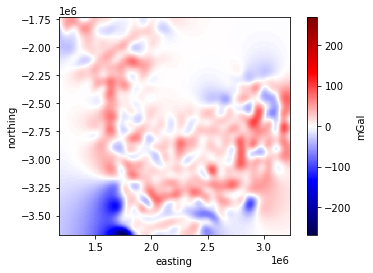

In [22]:
tmp = grid.gravity_disturbance.plot.pcolormesh(cmap="seismic", add_colorbar=False)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

## Get a better grid using Cross Validation

In [45]:
import itertools

dampings = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
depths = [100, 500, 1e3, 5e3, 10e3, 20e3, 30e3, 40e3]

parameters_sets = [
    dict(damping=combo[0], relative_depth=combo[1])
    for combo in itertools.product(dampings, depths)
]

In [46]:
parameters_sets

[{'damping': 1e-05, 'relative_depth': 100},
 {'damping': 1e-05, 'relative_depth': 500},
 {'damping': 1e-05, 'relative_depth': 1000.0},
 {'damping': 1e-05, 'relative_depth': 5000.0},
 {'damping': 1e-05, 'relative_depth': 10000.0},
 {'damping': 1e-05, 'relative_depth': 20000.0},
 {'damping': 1e-05, 'relative_depth': 30000.0},
 {'damping': 1e-05, 'relative_depth': 40000.0},
 {'damping': 0.0001, 'relative_depth': 100},
 {'damping': 0.0001, 'relative_depth': 500},
 {'damping': 0.0001, 'relative_depth': 1000.0},
 {'damping': 0.0001, 'relative_depth': 5000.0},
 {'damping': 0.0001, 'relative_depth': 10000.0},
 {'damping': 0.0001, 'relative_depth': 20000.0},
 {'damping': 0.0001, 'relative_depth': 30000.0},
 {'damping': 0.0001, 'relative_depth': 40000.0},
 {'damping': 0.001, 'relative_depth': 100},
 {'damping': 0.001, 'relative_depth': 500},
 {'damping': 0.001, 'relative_depth': 1000.0},
 {'damping': 0.001, 'relative_depth': 5000.0},
 {'damping': 0.001, 'relative_depth': 10000.0},
 {'damping': 0

In [47]:
print("Total number of dampings:", len(dampings))
print("Total number of depths:", len(depths))

print("Number of possible combinations:", len(dampings) * len(depths))

Total number of dampings: 5
Total number of depths: 8
Number of possible combinations: 40


In [48]:
print("Number of parameters sets:", len(parameters_sets))

Number of parameters sets: 40


In [113]:
gridder = hm.EQLHarmonic()
cross_validator = vd.BlockKFold(spacing=10e3, random_state=0)

scores_delayed = []
for parameters in parameters_sets:
    gridder.set_params(**parameters)
    score = np.mean(vd.cross_val_score(gridder, coordinates, data.gravity_disturbance, cv=cross_validator, delayed=True))
    scores_delayed.append(score)

In [114]:
import dask
scores = dask.compute(*scores_delayed)

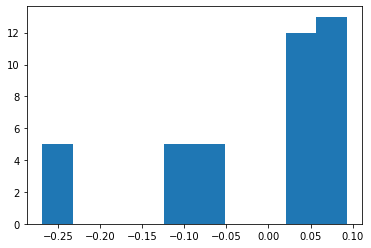

In [115]:
plt.hist(scores, density=False)
plt.show()

In [116]:
np.max(scores)

0.09276943243040162

In [117]:
best = np.argmax(scores)
best_parameters = parameters_sets[best]
print("Best score:", scores[best])
print("Best parameters:", best_parameters)

Best score: 0.09276943243040162
Best parameters: {'damping': 0.1, 'relative_depth': 30000.0}


In [118]:
gridder = hm.EQLHarmonic(**best_parameters)
gridder.fit(coordinates, data.gravity_disturbance)

gridder.extra_coords_name = "upward"
grid = gridder.grid(spacing=5e3, extra_coords=2500, data_names=["gravity_disturbance"])

In [119]:
grid

<xarray.Dataset>
Dimensions:              (easting: 412, northing: 388)
Coordinates:
  * easting              (easting) float64 1.177e+06 1.182e+06 ... 3.231e+06
  * northing             (northing) float64 -3.669e+06 -3.664e+06 ... -1.735e+06
    upward               (northing, easting) float64 2.5e+03 2.5e+03 ... 2.5e+03
Data variables:
    gravity_disturbance  (northing, easting) float64 -8.185 -8.315 ... 2.722
Attributes:
    metadata:  Generated by EQLHarmonic(damping=0.1, relative_depth=30000.0)

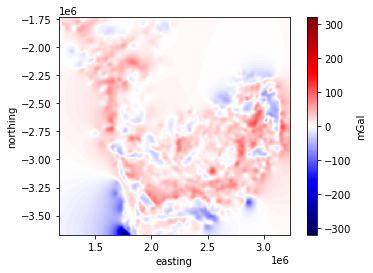

In [120]:
tmp = grid.gravity_disturbance.plot.pcolormesh(cmap="seismic", add_colorbar=False)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

In [121]:
masked_grid = vd.distance_mask(coordinates[:2], maxdist=70e3, grid=grid)

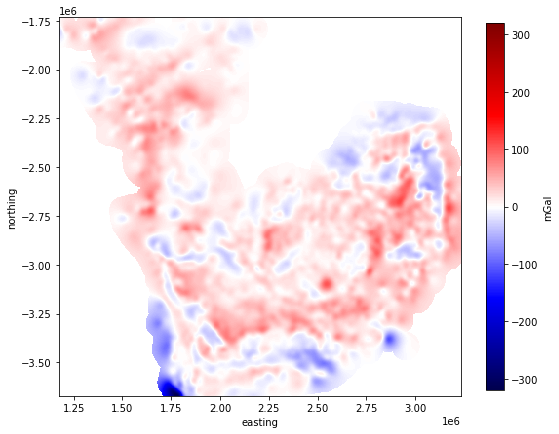

In [149]:
tmp = masked_grid.gravity_disturbance.plot.pcolormesh(cmap="seismic", add_colorbar=False)
plt.gca().set_aspect("equal")
plt.gcf().set_size_inches(9, 9)
plt.colorbar(tmp, label="mGal", shrink=0.75)
plt.show()

### Get a profile out of the Equivalent Layer model

In [141]:
point1 = (1.75e6, -3.5e6)
point2 = (3e6, -2.75e6)

profile = gridder.profile(point1, point2, size=250, extra_coords=2500, data_names=["gravity_disturbance"])

In [142]:
profile

,northing,easting,distance,upward,gravity_disturbance
0,-3.500000e+06,1.750000e+06,0.000000e+00,2500.0,-21.612135
1,-3.496988e+06,1.755020e+06,5.854369e+03,2500.0,-15.223710
2,-3.493976e+06,1.760040e+06,1.170874e+04,2500.0,-7.789049
3,-3.490964e+06,1.765060e+06,1.756311e+04,2500.0,-0.583466
4,-3.487952e+06,1.770080e+06,2.341748e+04,2500.0,4.781097
...,...,...,...,...,...
245,-2.762048e+06,2.979920e+06,1.434320e+06,2500.0,57.055926
246,-2.759036e+06,2.984940e+06,1.440175e+06,2500.0,56.902406
247,-2.756024e+06,2.989960e+06,1.446029e+06,2500.0,55.285029
248,-2.753012e+06,2.994980e+06,1.451884e+06,2500.0,51.814145


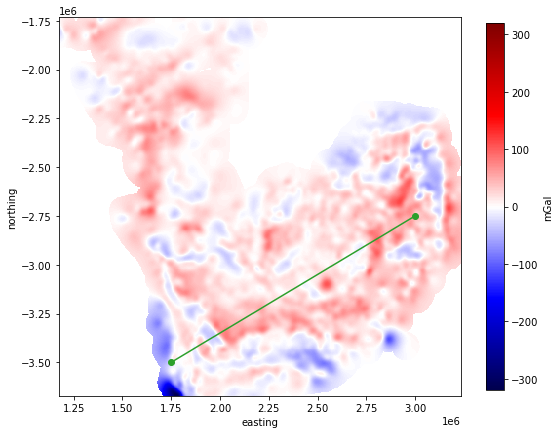

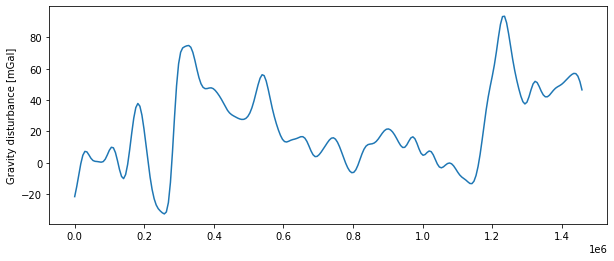

In [151]:
tmp = masked_grid.gravity_disturbance.plot.pcolormesh(cmap="seismic", add_colorbar=False)
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], c="C2", marker="o")
plt.gca().set_aspect("equal")
plt.gcf().set_size_inches(9, 9)
plt.colorbar(tmp, label="mGal", shrink=0.75)
plt.show()

plt.plot(profile.distance, profile.gravity_disturbance)
plt.gcf().set_size_inches(10, 4)
plt.ylabel("Gravity disturbance [mGal]")
plt.show()